# Models 09
*Anders Poirel*

Ideas:
- ensembling the top 3 models so far on the lag52 data (random forest, svm and xgboost)

In [3]:
%cd ..

C:\Users\Anders\Documents\data-science-projects\dss-diseasespread


In [4]:
import numpy as np
import pandas as pd 
import os 

from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.linear_model import RidgeRegression
from sklearn.model_selection import cross_validate, TimeSeriesSplit
from sklearn.pipeline import make_pipeline 
from sklearn.preprocessing import StandardScaler 
from sklearn.svm import LinearSVR
from xgboost import XGBRegressor

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

from src.models.utilities import build_submission

In [5]:
mpl.rcParams.update({
    'figure.autolayout': True,
    'figure.dpi': 150
})
sns.set()

## Reading the data

In [6]:
DATA_PATH = 'data/processed'
PRED_PATH = 'models'

In [8]:
X_train = pd.read_csv(os.path.join(DATA_PATH, 'lag52_train_features.csv'))
X_test = pd.read_csv(os.path.join(DATA_PATH, 'lag52_test_features.csv'))
y_train = pd.read_csv(os.path.join(DATA_PATH, 'lag52_train_labels.csv'))

In [9]:
X_train_sj = X_train[X_train['city'] == 'sj'].drop('city', axis = 1)
X_train_iq = X_train[X_train['city'] == 'iq'].drop('city', axis = 1)

X_test_sj = X_test[X_test['city'] == 'sj'].drop('city', axis = 1)
X_test_iq = X_test[X_test['city'] == 'iq'].drop('city', axis = 1)

y_train_sj = y_train[y_train['city'] == 'sj']['total_cases'].astype('float')
y_train_iq = y_train[y_train['city'] == 'iq']['total_cases'].astype('float')

## Models

Throughout, parameters found to be good in previous noteboos (`07`, `08`) are used 

### San Juan

Linear support vector machine

In [10]:
svr_sj = make_pipeline(
    SelectKBest(f_regression, k = 100),
    StandardScaler(),
    LinearSVR(C = 0.1)
)

Random forest

In [11]:
rf_sj_model = RandomForestRegressor(
    max_depth = 3,
    max_features = None,
    min_impurity_decrease = 0.1
)
rf_sj = make_pipeline(
    SelectKBest(mutual_info_regression, k = 100),
    rf_sj_model
)

XGBoost

In [12]:
xgb_sj_model = XGBRegressor(
    learning_rate = 0.01,
    max_depth = 2,
    estimators = 50,
    reg_lambda = 1
)
xgb_sj = make_pipeline(
    SelectKBest(mutual_info_regression, k = 100),
    xgb_sj_model
)

Stacking

In [17]:
model_sj = StackingRegressor(
    estimators = [
        ('SVR', svr_sj), 
        ('random forest', rf_sj), 
        ('gradient boosting', xgb_sj)
    ],
    final_estimator = RidgeCV(
        alphas = [0.01, 0.1, 1, 10],
        normalize = True,
        cv = TimeSeriesSplit(5)
    ),
    n_jobs = -1
)

In [19]:
cv_sj = cross_validate(
    estimator = model_sj,
    scoring = 'neg_mean_absolute_error',
    X = X_train_sj,
    y = y_train_sj,
    cv = TimeSeriesSplit(5),
    n_jobs = -1,
    verbose = 10
)
print(np.mean(cv_sj['test_score']))
print(np.std(cv_sj['test_score']))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.4min remaining:  2.0min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  1.6min remaining:  1.1min


-34.58131214445889
8.938385818065528


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.0min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.0min finished


#### Visualization

In [ ]:
model_sj.fit(X_train_sj, y_train_sj)
y_val_sj = svr_sj.predict(X_train_sj).flatten()
fig, ax = plt.subplots(figsize = (10, 5))
sns.lineplot(y = y_train_sj, x = X_train_sj.index.values, ax = ax)
sns.lineplot(y = y_val_sj, x = X_train_sj.index.values, ax = ax)
ax.set(title = 'San Juan predictions on training data')
ax.legend(['True', 'Predicted'])

### Iquitos

Linear support vector machine

In [74]:
svr_iq = Pipeline([
    ('select', SelectKBest(f_regression, k = 100)),
    ('scale', StandardScaler()),
    ('linear', LinearSVR(C=0.04))
])

#### Visualization

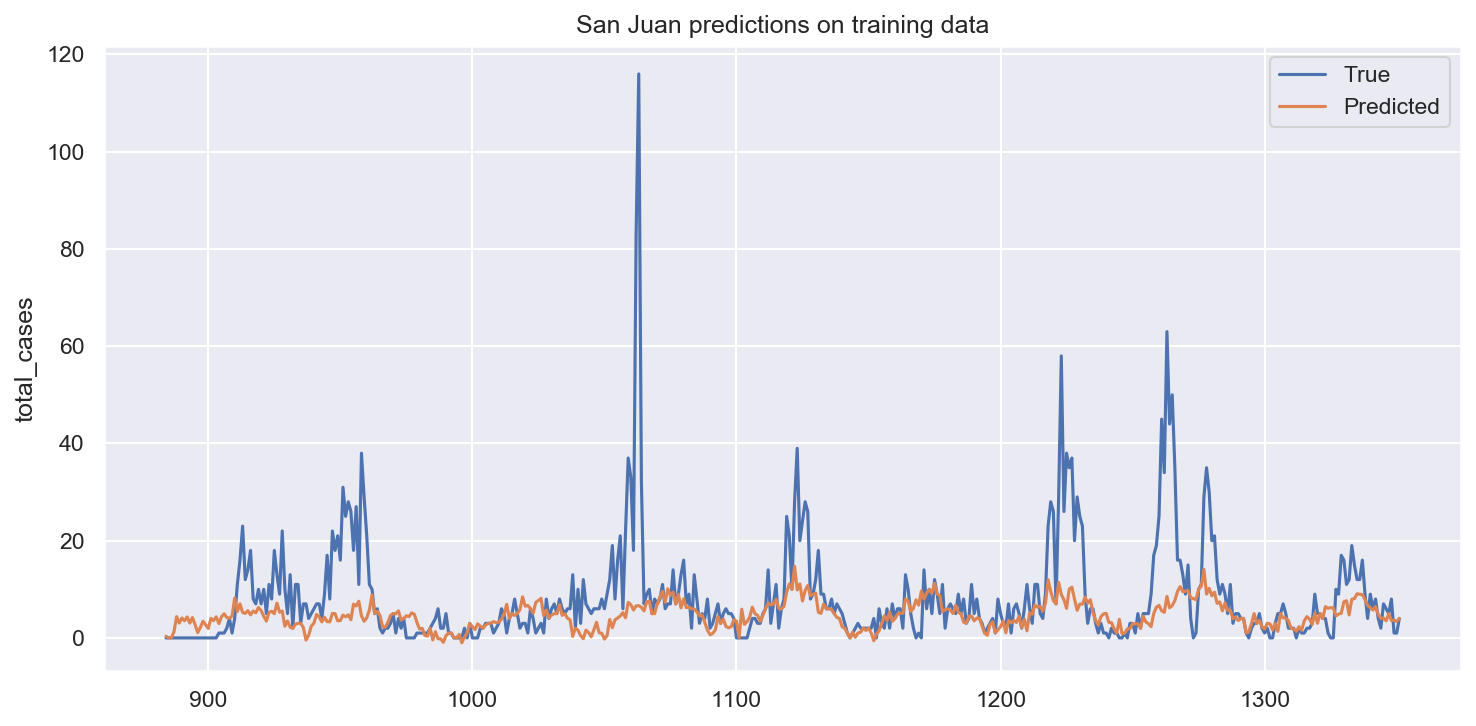

In [79]:
svr_iq.fit(X_train_iq, y_train_iq)
y_val_iq = svr_iq.predict(X_train_iq).flatten()
fig, ax = plt.subplots(figsize = (10, 5))
sns.lineplot(y = y_train_iq, x = X_train_iq.index.values, ax = ax)
sns.lineplot(y = y_val_iq, x = X_train_iq.index.values, ax = ax)
ax.set(title = 'San Juan predictions on training data')
ax.legend(['True', 'Predicted'])

### Overall performance

In [85]:
sj_ratio = len(X_train_sj) / len(X_train)
iq_ratio = len(X_train_iq) / len(X_train)

sj_ratio * np.mean(cv_sj['test_score']) + iq_ratio * np.mean(cv_iq['test_score'])

-17.635112796660124

## Submission

In [89]:
build_submission(
    svr_sj,
    svr_iq,
    X_test_sj,
    X_test_iq,
    'data/raw',
    PRED_PATH,
    'lag52_svm_2'
)

,city,year,weekofyear,total_cases
0,sj,2008,18,2
1,sj,2008,19,2
2,sj,2008,20,3
3,sj,2008,21,1
4,sj,2008,22,2
...,...,...,...,...
411,iq,2013,22,1
412,iq,2013,23,2
413,iq,2013,24,2
414,iq,2013,25,-1
